In [38]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import re
import json
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
from functools import partial

In [3]:
%load_ext autoreload
%autoreload 1
from utils.hourly_volas_and_dt import hourly_volas_and_dt
%aimport utils.hourly_volas_and_dt

In [4]:
from utils.rolling import rolling
%aimport utils.rolling

In [5]:
from utils.train_test_split import train_test_split
%aimport utils.train_test_split

In [6]:
from utils.loss_functions import mean_squared, quasi_likelihood
%aimport utils.loss_functions

In [7]:
from utils.r_squared_daily import r_squared_daily
%aimport utils.r_squared_daily

In [8]:
from utils.mean_squared_daily import mean_squared_daily
%aimport utils.mean_squared_daily

In [9]:
from utils.q_likelihood_daily import q_likelihood_daily
%aimport utils.q_likelihood_daily

In [10]:
def lagged_df(df, lag_days_list, blocks, symbol):
    df_lags_dict = {}
    for lag_day in range(1, max(lag_days_list) + 1):
        df_new = df.shift(lag_day * blocks)
        df_lags_dict[lag_day] = df_new.rename(columns = {symbol : lag_day})

    list_of_dfs = [df]
    list_of_dfs.extend(list(df_lags_dict.values()))
    return pd.concat(list_of_dfs, axis=1)

In [11]:
def prepare_model_df(df, lag_days, symbol):
    columns_to_use = [symbol]
    lags_to_use = [i for i in range(1, lag_days + 1)]
    columns_to_use.extend(lags_to_use)

    # set_trace()
    df_model = df[columns_to_use]
    df_model.dropna(inplace=True)
    X = df_model[lags_to_use]
    X = sm.add_constant(X)
    y = df_model[symbol]
    return y, X

In [12]:
def in_sample_AR_with_selection(input_folder_name, lag_days_list, symbol, data_type):
    volas = hourly_volas_and_dt(symbol, input_folder_name)
    
    if data_type == 'rolling':
        df = rolling(volas)
    if data_type == 'calen':
        df = volas.groupby(pd.Grouper(freq="D")).sum()

    df = lagged_df(df, lag_days_list)
    
    AR_results = dict()
    AICs = dict()
    for lag_days in lag_days_list:
        y, X = prepare_model_df(df, lag_days, symbol)
        res = sm.OLS(y, X).fit()
        AR_results[lag_days] = res
        AICs[lag_days] = res.aic
    return AR_results, AICs

In [125]:
def in_sample_AR(input_folder_name, lag_days, symbol, data_type):
    set_trace()
    volas = hourly_volas_and_dt(symbol, input_folder_name)
    
    if data_type == 'Rolling':
        df = rolling(volas)
        blocks = 24
    if data_type == 'Calendar':
        df = volas.groupby(pd.Grouper(freq="D")).sum()
        blocks = 1
    
    lag_days_list = [i for i in range(1, lag_days + 1)]
    df = lagged_df(df, lag_days_list, blocks, symbol)
    
    y, X = prepare_model_df(df, lag_days, symbol)
    res = sm.OLS(y, X).fit()
    return res, y, X

In [14]:
def in_sample_HAR(input_folder_name, symbol, data_type):
    volas = hourly_volas_and_dt(symbol, input_folder_name)
    if data_type == 'Calendar':
        df = volas.groupby(pd.Grouper(freq="D")).sum()
        df.rename(columns={symbol : 'd'}, inplace=True)
        df['w'] = df['d'].rolling(7).sum() / 7
        df['m'] = df['d'].rolling(30).sum() / 30
        df['d_next'] = df['d'].shift(-1)
        df.dropna(inplace=True)
        X = df[['d', 'w', 'm']]
        X = sm.add_constant(X)
        y = df['d_next']
        res = sm.OLS(y, X).fit()
    if data_type == 'Rolling':
        df = volas.rolling(24).sum()
        df.rename(columns={symbol : 'd'}, inplace=True)
        df['w'] = (volas.rolling(7 * 24).sum() / 7)
        df['m'] = (volas.rolling(30 * 24).sum() / 30)
        df = df.shift(periods=1, freq="h") # using end-representation
        df['d_next'] = df['d'].shift(-24)
        df.dropna(inplace=True)
        X = df[['d', 'w', 'm']]
        X = sm.add_constant(X)
        y = df['d_next']
        res = sm.OLS(y, X).fit()
    return res, y, X

In [15]:
def in_sample_HAR_plus_I(input_folder_name, symbol, data_type):
    volas = hourly_volas_and_dt(symbol, input_folder_name)
    if data_type == 'Calendar':
        df = volas.groupby(pd.Grouper(freq="D")).sum()
        df.rename(columns={symbol : 'd'}, inplace=True)
        df['w'] = df['d'].rolling(7).sum()
        df['m'] = df['d'].rolling(30).sum()
        df['d_next'] = df['d'].shift(-1)
        df['6h'] = volas.rolling(6).sum().shift(-5)
        df['12h'] = volas.rolling(12).sum().shift(-11)
        df['18h'] = volas.rolling(18).sum().shift(-17)
        df.dropna(inplace=True)
        X = df[['d', 'w', 'm', '6h', '12h', '18h']]
        X = sm.add_constant(X)
        y = df['d_next']
        res = sm.OLS(y, X).fit()
    if data_type == 'Rolling':
        df = volas.rolling(24).sum()
        df.rename(columns={symbol : 'd'}, inplace=True)
        df['w'] = volas.rolling(7 * 24).sum() / 7
        df['m'] = volas.rolling(30 * 24).sum() / 30
        df['6h'] = volas.rolling(6).sum() / 6 * 24
        df['12h'] = volas.rolling(12).sum() / 12 * 24
        df['18h'] = volas.rolling(18).sum() / 18 * 24
        df = df.shift(periods=1, freq="h") # using end-representation
        df['d_next'] = df['d'].shift(-24)
        df.dropna(inplace=True)
        X = df[['d', 'w', 'm', '6h', '12h', '18h']]
        X = sm.add_constant(X)
        y = df['d_next']
        res = sm.OLS(y, X).fit()
    return res, y, X

In [130]:
def make_empty_results():
    model_names = list(model_name_to_coefs.keys())
    data_type_names = ['Calendar', 'Rolling']
    # coef_names = ["$\\alpha$", "$\\beta^{(d)}_1$", "$\\beta^{(d)}_{2\\sim1}$", "$\\beta^{(d)}_{3\\sim2}$", 
    #               "$\\beta^{(w)}$", "$\\beta^{(m)}$",
    #               "$\\beta^{(h)}_6$", "$\\beta^{(h)}_{12}$", "$\\beta^{(h)}_{18}$"
    #              ]
    coef_names = list(set([item for sublist in model_name_to_coefs.values() for item in sublist]))
    coef_detail_names = ['coef.', 'std.err.']
    summary_names = ['$R^2$', 'MSE', 'QLIKE']

    column_iterable = [model_names, data_type_names]
    column_iterable_name = ["Model", "Data"]
    column_index = pd.MultiIndex.from_product(column_iterable, names=column_iterable_name)

    row_iterable = [coef_names, coef_detail_names]
    row_index = pd.MultiIndex.from_product(row_iterable)
    row_summary_index = pd.MultiIndex.from_product([summary_names, ["val."]])
    row_index = row_index.append(row_summary_index)
    
    df_length = 2 * len(coef_names) + len(summary_names)
    
    return pd.DataFrame(np.full([df_length, 8], np.nan), index=row_index, columns=column_index)

In [32]:
def write_to_results_df(res, y, X, model_name, coef_names_used, data_type, results):
    summary_names = ['$R^2$', 'MSE', 'QLIKE']
    new = res.get_robustcov_results(cov_type='HAC', maxlags=5)
    for coef_name, coef in zip(coef_names_used, new.params):
        results[model_name, data_type].loc[coef_name, "coef."] = coef
    for coef_name, std_err in zip(coef_names_used, new.bse):
        results[model_name, data_type].loc[coef_name, "std.err."] = std_err
    summaries = [
        r_squared_daily(y, X, new), 
        mean_squared_daily(y, X, new), 
        q_likelihood_daily(y, X, new)
    ]
    for summary_name, summary in zip(summary_names, summaries):
        results[model_name, data_type].loc[summary_name, "val."] = summary

In [96]:
model_name_to_function = {
    'AR(1)' : partial(in_sample_AR, lag_days=1),
    'AR(30)' : partial(in_sample_AR, lag_days=30),
    'HAR' : in_sample_HAR,
    'HAR+I' : in_sample_HAR_plus_I
}

In [129]:
list(model_name_to_coefs.keys())

['AR(1)', 'AR(30)', 'HAR', 'HAR+I']

In [101]:
orig = ["$\\alpha$", "$\\beta^{(d)}_1$"]

In [102]:
["$\\alpha$", "$\\beta^{(d)}_1$"] + [f"$\\beta^{{(d)}}_{{{i + 1}\\sim{i}}}$" for i in range(1, 30)]

['$\\alpha$',
 '$\\beta^{(d)}_1$',
 '$\\beta^{(d)}_{2\\sim1}$',
 '$\\beta^{(d)}_{3\\sim2}$',
 '$\\beta^{(d)}_{4\\sim3}$',
 '$\\beta^{(d)}_{5\\sim4}$',
 '$\\beta^{(d)}_{6\\sim5}$',
 '$\\beta^{(d)}_{7\\sim6}$',
 '$\\beta^{(d)}_{8\\sim7}$',
 '$\\beta^{(d)}_{9\\sim8}$',
 '$\\beta^{(d)}_{10\\sim9}$',
 '$\\beta^{(d)}_{11\\sim10}$',
 '$\\beta^{(d)}_{12\\sim11}$',
 '$\\beta^{(d)}_{13\\sim12}$',
 '$\\beta^{(d)}_{14\\sim13}$',
 '$\\beta^{(d)}_{15\\sim14}$',
 '$\\beta^{(d)}_{16\\sim15}$',
 '$\\beta^{(d)}_{17\\sim16}$',
 '$\\beta^{(d)}_{18\\sim17}$',
 '$\\beta^{(d)}_{19\\sim18}$',
 '$\\beta^{(d)}_{20\\sim19}$',
 '$\\beta^{(d)}_{21\\sim20}$',
 '$\\beta^{(d)}_{22\\sim21}$',
 '$\\beta^{(d)}_{23\\sim22}$',
 '$\\beta^{(d)}_{24\\sim23}$',
 '$\\beta^{(d)}_{25\\sim24}$',
 '$\\beta^{(d)}_{26\\sim25}$',
 '$\\beta^{(d)}_{27\\sim26}$',
 '$\\beta^{(d)}_{28\\sim27}$',
 '$\\beta^{(d)}_{29\\sim28}$',
 '$\\beta^{(d)}_{30\\sim29}$']

In [118]:
a = list(set([item for sublist in model_name_to_coefs.values() for item in sublist]))

In [119]:
a

['$\\alpha$',
 '$\\beta^{(d)}_1$',
 '$\\beta^{(d)}_{10\\sim9}$',
 '$\\beta^{(d)}_{11\\sim10}$',
 '$\\beta^{(d)}_{12\\sim11}$',
 '$\\beta^{(d)}_{13\\sim12}$',
 '$\\beta^{(d)}_{14\\sim13}$',
 '$\\beta^{(d)}_{15\\sim14}$',
 '$\\beta^{(d)}_{16\\sim15}$',
 '$\\beta^{(d)}_{17\\sim16}$',
 '$\\beta^{(d)}_{18\\sim17}$',
 '$\\beta^{(d)}_{19\\sim18}$',
 '$\\beta^{(d)}_{20\\sim19}$',
 '$\\beta^{(d)}_{21\\sim20}$',
 '$\\beta^{(d)}_{22\\sim21}$',
 '$\\beta^{(d)}_{23\\sim22}$',
 '$\\beta^{(d)}_{24\\sim23}$',
 '$\\beta^{(d)}_{25\\sim24}$',
 '$\\beta^{(d)}_{26\\sim25}$',
 '$\\beta^{(d)}_{27\\sim26}$',
 '$\\beta^{(d)}_{28\\sim27}$',
 '$\\beta^{(d)}_{29\\sim28}$',
 '$\\beta^{(d)}_{2\\sim1}$',
 '$\\beta^{(d)}_{30\\sim29}$',
 '$\\beta^{(d)}_{3\\sim2}$',
 '$\\beta^{(d)}_{4\\sim3}$',
 '$\\beta^{(d)}_{5\\sim4}$',
 '$\\beta^{(d)}_{6\\sim5}$',
 '$\\beta^{(d)}_{7\\sim6}$',
 '$\\beta^{(d)}_{8\\sim7}$',
 '$\\beta^{(d)}_{9\\sim8}$',
 '$\\beta^{(h)}_6$',
 '$\\beta^{(h)}_{12}$',
 '$\\beta^{(h)}_{18}$',
 '$\\beta^{(m)

In [103]:
model_name_to_coefs = {
    'AR(1)' : ["$\\alpha$", "$\\beta^{(d)}_1$"],
    'AR(30)' : ["$\\alpha$", "$\\beta^{(d)}_1$"] + [f"$\\beta^{{(d)}}_{{{i + 1}\\sim{i}}}$" for i in range(1, 30)],
    'HAR' : ["$\\alpha$", "$\\beta^{(d)}_1$", "$\\beta^{(w)}$", "$\\beta^{(m)}$"],
    'HAR+I' : [
        "$\\alpha$", "$\\beta^{(d)}_1$", "$\\beta^{(w)}$", "$\\beta^{(m)}$", 
        "$\\beta^{(h)}_6$", "$\\beta^{(h)}_{12}$", "$\\beta^{(h)}_{18}$"
    ]
}

In [104]:
def in_sample(
    input_folder_name, symbols_list, model_name_to_function, model_name_to_coefs, out_folder,
):
    symbol_to_results = dict()
    out_file_prefix = out_folder + '/in_sample_'
    out_file_suffix = '.tex'
    for symbol in symbols_list:
        try:
            results = make_empty_results()
            for data_type in ['Calendar', 'Rolling']:
                for model_name, function in model_name_to_function.items():
                    coef_names_used = model_name_to_coefs[model_name]
                    res, y, X = function(
                        input_folder_name=input_folder_name, 
                        symbol=symbol, 
                        data_type=data_type,
                    )
                    write_to_results_df(res, y, X, model_name, coef_names_used, data_type, results)
            symbol_to_results[symbol] = results
            file_name = out_file_prefix + symbol + out_file_suffix
            # results.to_latex(
            #     file_name,
            #     escape=False, 
            #     float_format="%.5f", 
            #     multirow=True, 
            #     na_rep="", 
            #     multicolumn_format="c",
            # )
            print(f"Success for {symbol}.")
        except Exception as e:
            print(f"Failure for {symbol}.")
            print(e)
    return symbol_to_results

In [122]:
from IPython.core.debugger import set_trace

In [126]:
def main():
    symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
    with open(symbols_list_file_name, "r") as f:
        symbols_list = json.load(f)
    symbols_list.remove('scbtc')

    input_folder_name = "full_returns_winsorised"
    out_folder = 'results'
    
    # set_trace()
    symbol_to_results = in_sample(
        input_folder_name, symbols_list, model_name_to_function, model_name_to_coefs, out_folder,
    )

    summary_names = ['$R^2$', 'MSE', 'QLIKE']

    list_of_dfs = []
    for results in symbol_to_results.values():
        df = results.loc[summary_names]
        list_of_dfs.append(df)
    summary_means = pd.concat(list_of_dfs).groupby(level=0).mean()

    file_name = 'results/in_sample_summary.tex'
    
    precision_digits = 3
    format_type='g'
    alternate = '#'
    my_formatter = f"{{:{alternate}.{precision_digits}{format_type}}}".format

    summary_means.to_latex(
        file_name,
        escape=False, 
        float_format=my_formatter, 
        multirow=True, 
        na_rep="", 
        multicolumn_format="c",
    )

In [131]:
main()

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Success for bnbbtc.
Success for adabtc.
Success for ethbtc.
Success for batbtc.
Success for btcusdc.
Success for btcusdt.
Success for neobtc.
Success for btctusd.
Success for etcbtc.
Success for ltcbtc.
Success for xrpbtc.
Success for trxbtc.
Success for eosbtc.
Success for xmrbtc.
Success for zecbtc.
Success for qtumbtc.
Success for dcrbtc.
Success for xlmbtc.
Success for iotabtc.
Success for manabtc.
Success for dashbtc.
Success for zrxbtc.
Success for repbtc.


In [ ]:
def print_latex_code_for_all_symbols():
    symbols_list_large = [symbol.upper() for symbol in symbols_list]

    for symbol, symbol_large in zip(symbols_list, symbols_list_large):
        s = '''
        \\begin{table}[]
        \small
        \\begin{adjustwidth}{-0.8in}{-0.8in}
        \input{results/in_sample_%s.tex}
        \end{adjustwidth}
            \caption{In-sample coefficients and summaries for volatility regressions for the cryptoasset pair %s using all 3 years of data. We report Newey-West robust standard errors with maximum 5 lags. The $R^2$, MSE, and QLIKE for Rolling data are computed using end-of-day data only to allow for comparison with those for Calendar data.}
            \label{tab:in_sample_%s}
        \end{table}
        ''' % (symbol, symbol_large, symbol)
        print(s)

In [284]:
# r, a = in_sample_AR_with_selection(input_folder_name, lag_days_list, symbol, 'rolling')

# best_lag = dict()

# for symbol in symbols_list:
#     r, a = in_sample_AR_with_selection(input_folder_name, lag_days_list, symbol, 'rolling')
#     b = min(a, key=a.get)
#     best_lag[symbol] = b

In [285]:
# best_lag

{'bnbbtc': 3,
 'adabtc': 4,
 'ethbtc': 4,
 'batbtc': 1,
 'btcusdc': 3,
 'btcusdt': 3,
 'neobtc': 3,
 'btctusd': 4,
 'etcbtc': 3,
 'ltcbtc': 3,
 'xrpbtc': 3,
 'trxbtc': 3,
 'eosbtc': 3,
 'xmrbtc': 3,
 'zecbtc': 4,
 'qtumbtc': 4,
 'dcrbtc': 4,
 'xlmbtc': 1,
 'iotabtc': 3,
 'manabtc': 3,
 'dashbtc': 4,
 'zrxbtc': 1,
 'scbtc': 3,
 'repbtc': 1}

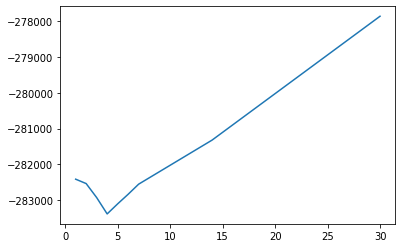

In [263]:
# plt.plot(lag_days_list, list(AICs.values()))

In [267]:
# min(AICs, key=AICs.get)

4

In [264]:
# AICs

{1: -282413.32363064075,
 2: -282536.0615502746,
 3: -282927.33722002874,
 4: -283384.1961564978,
 5: -283103.32663714397,
 6: -282834.9751534167,
 7: -282552.74119831336,
 14: -281320.30666379665,
 30: -277858.7621947678}

<AxesSubplot:>

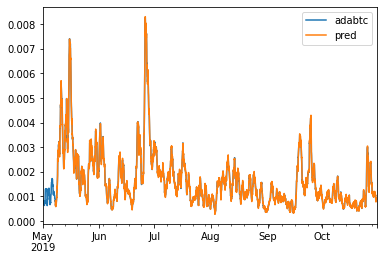

In [65]:
# predictions = res.predict()
# df_res = volas_train_rolled.copy(deep=True)
# df_res["pred"] = predictions
# ((df_res['adabtc'] - df_res['pred']) ** 2).sum()
# df_res.plot()